<a href="https://colab.research.google.com/github/Manikantaamanchi424/Infosys-Intern-Project/blob/main/Assignment_03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Assignment-3
Compare Linear Regression Models with Default vs. Custom Parameters for Earthquake Magnitude Prediction

Objective:
Train and analyze two linear regression models to predict earthquake Magnitude: one with default parameters and one with custom-tuned parameters. Compare their performances and interpret findings, and last provide a summary report.

In [ ]:
# Block 1: Install & Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [ ]:
# Block 2: Load Data
df = pd.read_csv("/content/preprocessed_earthquake_data.csv")
target_col = "Magnitude"
df = df.dropna(subset=[target_col]).reset_index(drop=True)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove(target_col)
df[numeric_cols] = df[numeric_cols].fillna(df[numeric_cols].median())
X = df[numeric_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# Block 3: Default Linear Regression
pipe_lr = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])
pipe_lr.fit(X_train, y_train)
y_pred_lr = pipe_lr.predict(X_test)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "MSE": mse, "RMSE": rmse, "R2": r2}

results = {}
results["LinearRegression_default"] = evaluate_model(y_test, y_pred_lr)
cv_scores_lr = cross_val_score(pipe_lr, X, y, cv=5, scoring="r2")


In [ ]:
# Block 4: Ridge Regression with GridSearch
pipe_ridge = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", Ridge(random_state=42))
])

param_grid = {
    "ridge__alpha": [0.0, 0.01, 0.1, 1.0, 10.0, 50.0],
    "ridge__fit_intercept": [True, False]
}

grid = GridSearchCV(pipe_ridge, param_grid, cv=5, scoring="r2", n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)
best_ridge = grid.best_estimator_
y_pred_ridge = best_ridge.predict(X_test)

results["Ridge_tuned"] = evaluate_model(y_test, y_pred_ridge)
cv_scores_ridge = cross_val_score(best_ridge, X, y, cv=5, scoring="r2")


Fitting 5 folds for each of 12 candidates, totalling 60 fits


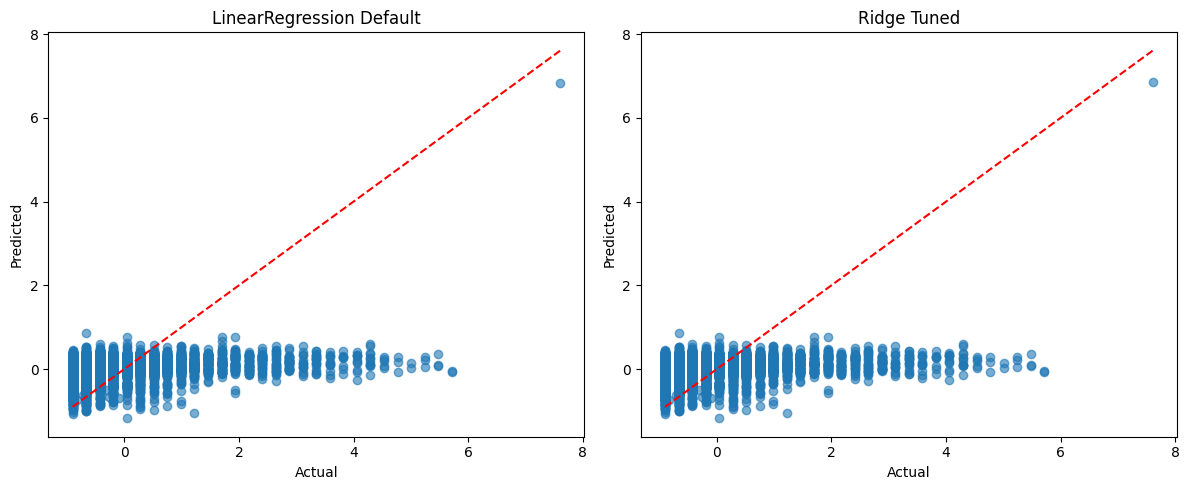

In [ ]:
# Block 5: Plots
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.scatter(y_test, y_pred_lr, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("LinearRegression Default")

plt.subplot(1,2,2)
plt.scatter(y_test, y_pred_ridge, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Ridge Tuned")
plt.tight_layout()
plt.show()


In [ ]:
# Block 6: Coefficients
def get_coefficients(pipeline, feature_names):
    scaler = pipeline.named_steps["scaler"]
    model = pipeline.named_steps[list(pipeline.named_steps.keys())[-1]]
    coef_scaled = model.coef_
    coef_orig = coef_scaled / scaler.scale_
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef_original": coef_orig
    }).sort_values(key=lambda c: c.abs(), by="coef_original", ascending=False)
    return coef_df

coef_lr = get_coefficients(pipe_lr, X.columns)
coef_ridge = get_coefficients(best_ridge, X.columns)
coef_lr.head(10), coef_ridge.head(10)


(               feature  coef_original
 29     Source_OFFICIAL       5.525298
 14   Magnitude Type_MH       1.280222
 22        Source_ATLAS      -1.162727
 21  Magnitude Type_MWW       1.095839
 28           Source_NN       1.083805
 24         Source_GCMT      -0.873236
 12     Type_Rock Burst       0.846075
 32           Source_US      -0.815029
 18  Magnitude Type_MWB       0.763067
 26    Source_ISCGEMSUP      -0.716351,
                feature  coef_original
 29     Source_OFFICIAL       5.551132
 14   Magnitude Type_MH       1.281945
 28           Source_NN       1.096780
 21  Magnitude Type_MWW       1.095054
 22        Source_ATLAS      -1.081423
 12     Type_Rock Burst       0.845981
 32           Source_US      -0.798197
 24         Source_GCMT      -0.791735
 18  Magnitude Type_MWB       0.762494
 30           Source_PR       0.722347)

In [ ]:
# Block 7: Results Summary
summary_df = pd.DataFrame(results).T
print(summary_df)
summary_df.to_csv("model_comparison_summary.csv", index=True)


                               MAE       MSE      RMSE        R2
LinearRegression_default  0.706962  0.943848  0.971518  0.091453
Ridge_tuned               0.707100  0.943846  0.971518  0.091454
